test generator

In [1]:
pip install scikit-image

     |████████████████████████████████| 13.9 MB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 12.1 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 11.7 MB/s eta 0:00:01
     |████████████████████████████████| 315 kB 11.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 12.1 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 10.5 MB/s eta 0:00:01
     |████████████████████████████████| 34.5 MB 71 kB/s s eta 0:00:01
     |████████████████████████████████| 220 kB 12.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
#from data_generator import *

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from skimage.draw import *

In [5]:
img = np.zeros((500, 500, 3), dtype=np.double)
img = np.zeros((500, 500, 3))

In [6]:
x_radius = 50
y_radius = 20
alpha = 3*np.pi/7
beta = 3*np.pi/15
test = [[(((x-200)*np.cos(alpha) + (y-30)*np.sin(alpha) ) / x_radius) ** 2 + (((x-200)*np.sin(alpha) - (y-30)*np.cos(alpha)) / y_radius) ** 2 - 1 for x in range(500)] for y in range(500)]
noise = -np.random.rand(500,500)*10
blurred = gaussian_filter(noise,sigma=2)
test = np.array(test) + blurred
test = np.where(test < 0, 1, 0)

In [7]:
def generate_cell(c_x,c_y,x_radius,y_radius,alpha,img_size,noise_strength,sigma_blur, class_nbr=1):
    def ellipse(x,y):
        return (((x-c_x)*np.cos(alpha) + (y-c_y)*np.sin(alpha) ) / x_radius) ** 2 + (((x-c_x)*np.sin(alpha) - (y-c_y)*np.cos(alpha)) / y_radius) ** 2 - 1
    
    img = [[ellipse(x,y) for x in range(img_size)] for y in range(img_size)]
    noise = np.random.normal(0,noise_strength,(img_size,img_size))
    blur = gaussian_filter(noise,sigma=sigma_blur)
    img = np.where(np.array(img) + blur < 0, class_nbr, 0)
    return img

In [8]:
def generate_cells(nb_cells,img_size, base_img = None, class_nbr=1):
    if base_img == None:
        img = np.zeros((img_size,img_size))
    else:
        img = base_img
    i = 0
    while i < nb_cells:
        c_x = np.random.randint(-10, img_size + 10)
        c_y = np.random.randint(-10, img_size + 10)
        x_radius = np.random.randint(15,30)
        y_radius = np.random.randint(15,30)
        alpha = np.random.uniform(0,2 *np.pi)
        temp_img = generate_cell(c_x,c_y,x_radius,y_radius,alpha,img_size,noise_strength = 2,sigma_blur=3.7, class_nbr = 1)
        if(np.sum(np.multiply(img,temp_img)) == 0):
            i+=1
            img+=temp_img
    return img

In [9]:
pip install perlin_noise

Note: you may need to restart the kernel to use updated packages.


In [10]:
image = generate_cells(13,256)
mask = image

In [11]:
from perlin_noise import PerlinNoise

def perlin():
    noise = PerlinNoise(octaves=10)
    h = 256
    w = 256
    mask = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            mask[i, j] = noise([(i / h)*0.15, (j / w)*0.15])

    # Normalize to range 0.7–1.3
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = 0.7 + mask * 0.6
    return mask



In [12]:
#bg_noise = np.abs(np.random.normal(0,1,(256,256)))
bg_noise = np.zeros((256,256))
cell_1_noise = gaussian_filter(np.abs(np.random.normal(2,2,(256,256))), sigma=2)
final_img = np.zeros((256,256))
final_img = np.where(image==1,cell_1_noise,bg_noise)
#Illumination 
noise = perlin()
final_img += noise*3
#Gaussian smoothin
final_img = gaussian_filter(final_img,sigma = 2)

#Poisson shot noise
poisson = np.random.poisson(final_img,size=(256,256))
final_img += poisson*0.5


## Testing stuff

In [13]:
def add_camera_noise(final_img,
                     exposure=20.0,     # photons per image intensity unit (higher -> stronger shot noise)
                     gain=1.0,          # electrons per photon (or conversion factor, often 1)
                     read_noise_sigma=2.0,  # Gaussian read noise (in electrons)
                     clip_range=(0, None)):


    signal = np.clip(final_img, 0, None)

    expected_photons = signal * exposure

    photons = np.random.poisson(expected_photons)

    electrons = photons * gain

    noisy_electrons = electrons + np.random.normal(0, read_noise_sigma, electrons.shape)

    noisy_image = noisy_electrons / (exposure * gain)

    noisy_image = np.clip(noisy_image, clip_range[0], clip_range[1] if clip_range[1] is not None else noisy_image.max())

    return noisy_image

In [14]:
image_test = add_camera_noise(final_img,
                         exposure=30.0,        # increase -> more photons -> relatively less Poisson noise
                         gain=1.0,
                         read_noise_sigma=1.5)

In [15]:
def add_correlated_noise(img, strength=0.15, beta=1.5):
   
    h, w = img.shape
    noise = np.random.normal(0, 1, (h, w))

    fy = np.fft.fftfreq(h).reshape(-1,1)
    fx = np.fft.fftfreq(w).reshape(1,-1)
    f = np.sqrt(fx*fx + fy*fy)
    f[0,0] = 1 

    filt = 1 / (f**beta)
    colored = np.real(np.fft.ifft2(np.fft.fft2(noise) * filt))
    colored = (colored - colored.min()) / (colored.max() - colored.min())

    return img + colored * strength

In [16]:
def add_internal_texture(img, mask):
    texture = gaussian_filter(np.random.normal(0, 1, img.shape), sigma=3)
    return img + texture * 0.15 * mask

In [17]:
def airy_psf(img, radius=1.5):
    from scipy.special import j1
    h, w = img.shape
    fy = np.fft.fftfreq(h).reshape(-1,1)
    fx = np.fft.fftfreq(w).reshape(1,-1)
    r = np.sqrt(fx*fx + fy*fy)
    psf = (2 * j1(2*np.pi*radius*r) / (2*np.pi*radius*r + 1e-6))
    filtered = np.fft.ifft2(np.fft.fft2(img) * psf)
    return np.real(filtered)

In [18]:
def smooth_mask(mask, sigma=2.0, edge_softness=12):
    blurred = gaussian_filter(mask.astype(float), sigma=sigma)
    blurred = (blurred - blurred.min()) / (blurred.max() - blurred.min())
    smooth = 1 / (1 + np.exp(-edge_softness * (blurred - 0.5)))
    return smooth

In [19]:
img = image
bg_noise = np.zeros((256,256))
cell_1_noise = gaussian_filter(np.abs(np.random.normal(2,2,(256,256))), sigma=2)
#Soft edges
soft = smooth_mask(mask)
img = bg_noise * (1 - soft) + cell_1_noise * soft
#Internal texture
img = add_internal_texture(img, mask)
#Perlin noise
illum = perlin()
img += illum*3.5
#Noise 
img = airy_psf(img)
# Poisson noise
img = add_camera_noise(img,exposure=10,gain=1,read_noise_sigma=2)
img = add_correlated_noise(img, strength=0.08, beta=1.4)
img = gaussian_filter(img,sigma = 0.5)

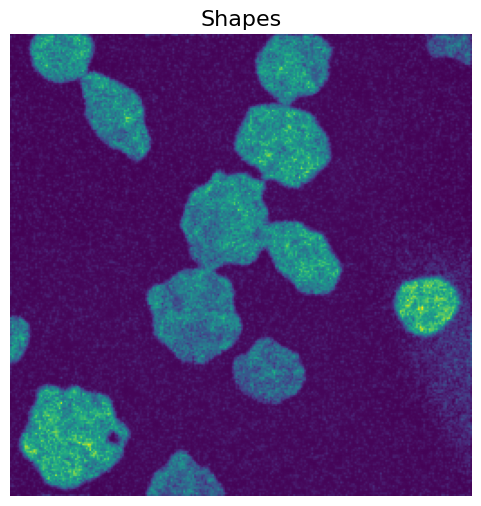

In [20]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax1.imshow(img)
ax1.set_title('Shapes',fontsize=16)
ax1.axis('off')
plt.show()

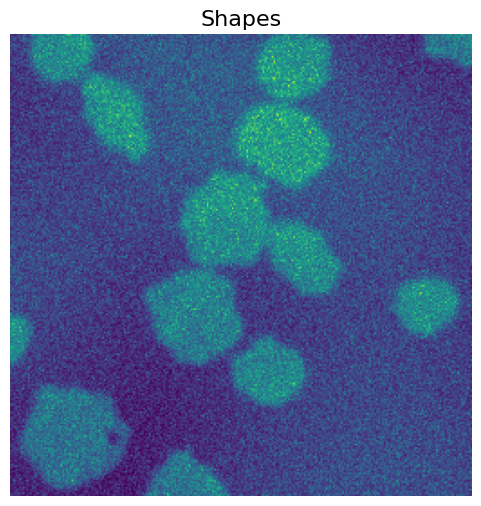

In [21]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax1.imshow(final_img)
ax1.set_title('Shapes',fontsize=16)
ax1.axis('off')
plt.show()

In [ ]:
from skimage import io, util
import os

def save_image(image,mask,path):
    image_u8 = util.img_as_ubyte(image/np.max(np.abs(image)))
    io.imsave(os.path.join('dataset/eroded-dilated','images',  f"{path}.png"), image_u8)
    mask_u8 = util.img_as_ubyte(mask/np.max(np.abs(mask)))
    io.imsave(os.path.join('dataset/eroded-dilated','masks',  f"{path}.png"), mask_u8)

    image = image.astype(np.float32)
    io.imsave(os.path.join('dataset/eroded-dilated','images',  f"{path}.tif"), image)
    mask = mask.astype(np.float32)
    io.imsave(os.path.join('dataset/eroded-dilated','masks',  f"{path}.tif"), mask)

In [54]:
import cv2

def morphological_filters(img, kernel, iterations):
    img_erosion = cv2.erode(img, kernel, iterations=iterations)
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=iterations) 
    return img_dilation

def morphological_filters_2(img, kernel_er,kernel_dil, iterations_er,iterations_dil):
    img_erosion = cv2.erode(img, kernel_er, iterations=iterations_er)
    img_dilation = cv2.dilate(img_erosion, kernel_dil, iterations=iterations_dil) 
    return img_dilation

In [82]:
path = '/home/unetgroup/Desktop/Project/ML-2025/projects/project2/dataset/generated_cells/masks/'
new_path = '/home/unetgroup/Desktop/Project/ML-2025/projects/project2/dataset/eroded-dilated_0.67/masks/'
from skimage import io, util
import os
for i in range(1,100):
    # Morphological filters
    if i not in [57,58,59]:
        old_mask = cv2.imread(f'{path}img_{i}.png')

        kernel_er = np.ones((6,6), np.uint8)
        iterations_er = 4
        kernel_dil = np.ones((6,6), np.uint8)
        iterations_dil = 4
        mask = morphological_filters_2(old_mask, kernel_er,kernel_dil, iterations_er,iterations_dil) / 255

        # SAVE MASK
        mask_u8 = util.img_as_ubyte(mask)
        io.imsave(f'{new_path}img_{i}.png', mask_u8)

        mask = mask.astype(np.float32)
        io.imsave(f'{new_path}img_{i}.tif', mask)



In [93]:
from skimage import io

mask = io.imread('/home/unetgroup/Desktop/Project/ML-2025/projects/project2/dataset/generated_cells/masks/img_92.tif').astype(np.float32)

print(np.count_nonzero(mask))
print(np.unique(mask))

28541
[0. 1.]


In [ ]:
for i in range(70,100):
    number_cells = np.random.randint(12, 30) # random number of cells
    image = generate_cells(number_cells,256)
    mask = image
    img = image

    # NOISE 

    bg_noise = np.zeros((256,256))
    cell_1_noise = gaussian_filter(np.abs(np.random.normal(2,2,(256,256))), sigma=2)
    #Soft edges
    soft = smooth_mask(mask)
    img = bg_noise * (1 - soft) + cell_1_noise * soft
    #Internal texture
    img = add_internal_texture(img, mask)
    #Perlin noise
    illum = perlin()
    img += illum*3.5
    #Noise 
    img = airy_psf(img)
    # Poisson noise
    img = add_camera_noise(img,exposure=10,gain=1,read_noise_sigma=2)
    img = add_correlated_noise(img, strength=0.08, beta=1.4)
    img = gaussian_filter(img,sigma = 0.5)

    # Morphological filters
    kernel = np.ones((3, 3), np.uint8)
    iterations = 8
    mask = morphological_filters(mask, kernel, iterations)
    
    
    # SAVE IMAGE + MASK
    save_image(img, mask, f"img_{i}")
    print(i)

KeyboardInterrupt: 

Apply erosion and dilation

In [24]:
pip install opencv2-python

ERROR: Could not find a version that satisfies the requirement opencv2-python (from versions: none)
ERROR: No matching distribution found for opencv2-python
Note: you may need to restart the kernel to use updated packages.


0.908858950806287


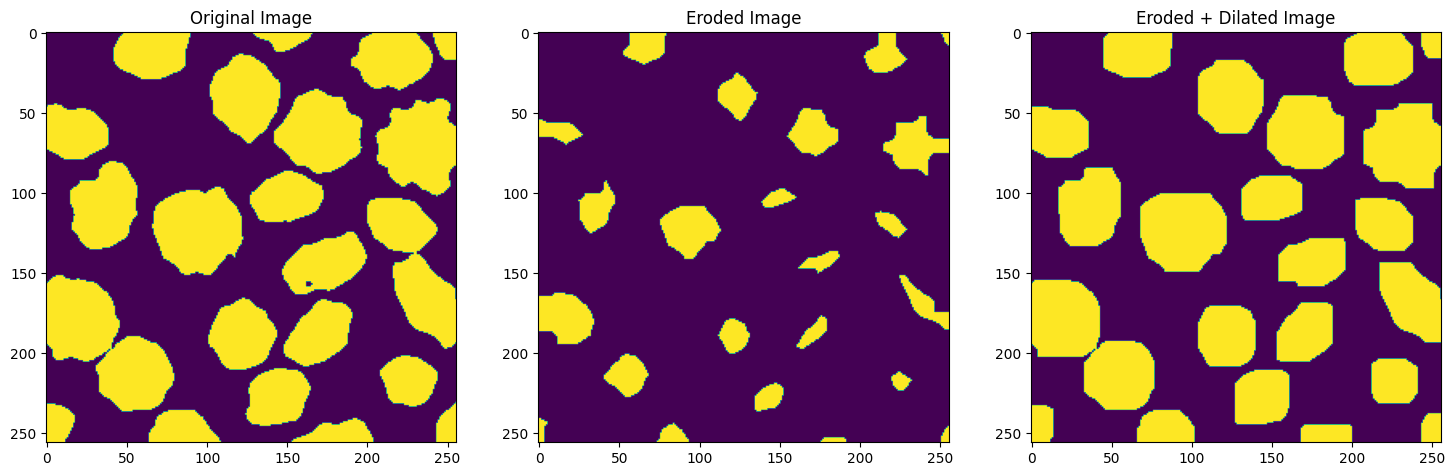

In [14]:
import cv2
from sklearn.metrics import jaccard_score
kernel = np.ones((5,5), np.uint8)
img = cv2.imread('dataset/generated_cells/masks/img_82.png')[:,:,0] / 255
iterations = 4
img_erosion = cv2.erode(img, kernel, iterations=iterations)
img_dilation = cv2.dilate(img_erosion, kernel, iterations=iterations)    # Restores the size of cells

# plot three images side by side
print(jaccard_score(img.reshape(-1),img_dilation.reshape(-1)))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(img)
ax2.imshow(img_erosion)
ax3.imshow(img_dilation)
ax1.set_title('Original Image')
ax2.set_title('Eroded Image')
ax3.set_title('Eroded + Dilated Image')
plt.show()

0.8445601143090427


/tmp/ipykernel_963083/2486370535.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 4, 2); plt.imshow(img);  plt.title("Ground Truth");  plt.axis('off')
/tmp/ipykernel_963083/2486370535.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 4, 3); plt.imshow(img_dilation);plt.title("Erosion + dilatation");    plt.axis('off')


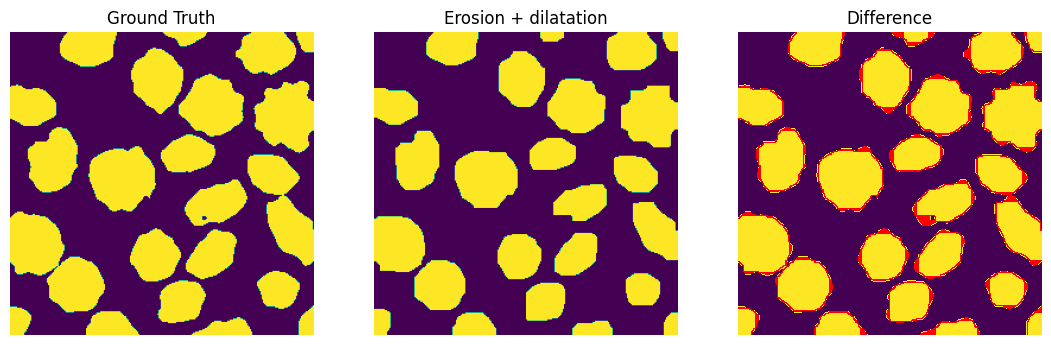

In [53]:
import cv2
from sklearn.metrics import jaccard_score
from matplotlib.colors import ListedColormap
kernel = np.ones((3,3), np.uint8)
kernel_erode = np.ones((5,5), np.uint8)
img = cv2.imread('dataset/generated_cells/masks/img_82.png')[:,:,0] / 255
iterations = 5
img_erosion = cv2.erode(img, kernel_erode, iterations=3)
img_dilation = cv2.dilate(img_erosion, kernel, iterations=iterations)    # Restores the size of cells

# plot three images side by side
print(jaccard_score(img.reshape(-1),img_dilation.reshape(-1)))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
# Define your custom color palette
custom_colors = ["#440154","#440154","#440154", "#fde724","#fde724","#fde724","#fde724","#ff0000","#ff0000","#ff0000"]

# Create a ListedColormap
custom_cmap = ListedColormap(custom_colors)


diff = np.where(((img == 0) & (img_dilation == 1)) | ((img == 1) & (img_dilation == 0)),1,np.where(img == 1,0.5,0))
# diff = np.where(((img == 1) & (img_dilation == 0)),1,np.where(img == 1,0.5,0))
# plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 2); plt.imshow(img);  plt.title("Ground Truth");  plt.axis('off')
plt.subplot(1, 4, 3); plt.imshow(img_dilation);plt.title("Erosion + dilatation");    plt.axis('off')
plt.subplot(1, 4, 4); plt.imshow(diff,cmap=custom_cmap);plt.title("Difference");    plt.axis('off')
plt.show()
# ax1.imshow(img)
# ax2.imshow(img_erosion)
# ax3.imshow(img_dilation)
# ax1.set_title('Original Image')
# ax2.set_title('Eroded Image')
# ax3.set_title('Eroded + Dilated Image')
plt.show()

0.6759457530335474


/tmp/ipykernel_963083/3449834614.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 4, 2); plt.imshow(img);  plt.title("Ground Truth");  plt.axis('off')
/tmp/ipykernel_963083/3449834614.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 4, 3); plt.imshow(img_dilation);plt.title("Prediction");    plt.axis('off')


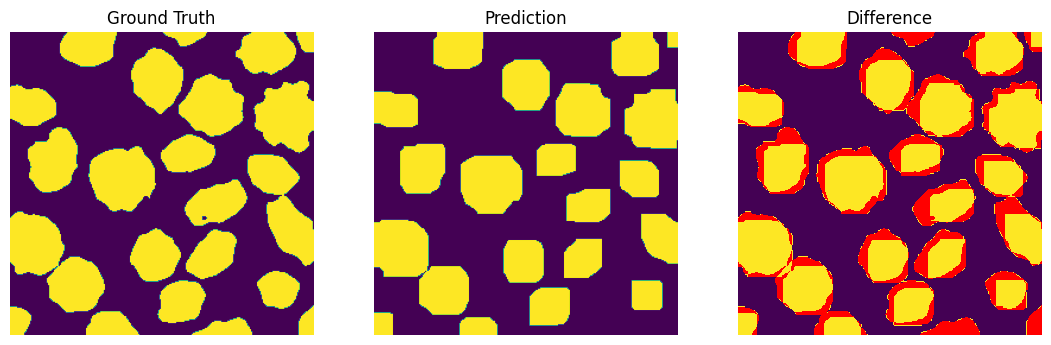

In [79]:
import cv2
from sklearn.metrics import jaccard_score
from matplotlib.colors import ListedColormap
kernel = np.ones((6,6), np.uint8)
img = cv2.imread('dataset/generated_cells/masks/img_82.png')[:,:,0] / 255
iterations = 4
img_erosion = cv2.erode(img, kernel, iterations=iterations)
img_dilation = cv2.dilate(img_erosion, kernel, iterations=iterations)    # Restores the size of cells

# plot three images side by side
print(jaccard_score(img.reshape(-1),img_dilation.reshape(-1)))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
# Define your custom color palette
custom_colors = ["#440154","#440154","#440154", "#fde724","#fde724","#fde724","#ff0000","#ff0000","#ff0000"]

# Create a ListedColormap
custom_cmap = ListedColormap(custom_colors)


diff = np.where(((img == 0) & (img_dilation == 1)) | ((img == 1) & (img_dilation == 0)),1,np.where(img == 1,0.5,0))
# plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 2); plt.imshow(img);  plt.title("Ground Truth");  plt.axis('off')
plt.subplot(1, 4, 3); plt.imshow(img_dilation);plt.title("Prediction");    plt.axis('off')
plt.subplot(1, 4, 4); plt.imshow(diff,cmap=custom_cmap);plt.title("Difference");    plt.axis('off')
plt.show()
# ax1.imshow(img)
# ax2.imshow(img_erosion)
# ax3.imshow(img_dilation)
# ax1.set_title('Original Image')
# ax2.set_title('Eroded Image')
# ax3.set_title('Eroded + Dilated Image')
plt.show()

Best results obtained with:
- kernel 5x5 and 3/4 iterations
- kernel 3x3 and 8 iterations

In [27]:
def morphological_filters(img, kernel, iterations):
    img_erosion = cv2.erode(img, kernel, iterations=iterations)
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=iterations)
    return img_dilation

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


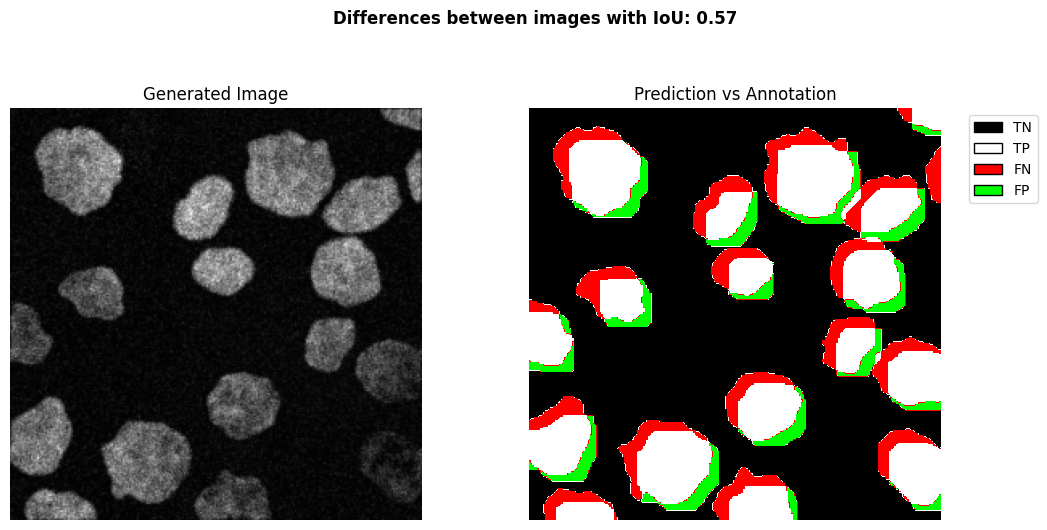

In [9]:
import cv2
from matplotlib.colors import ListedColormap
import data_loader 
nb = 17
iou = 0.57
mask = cv2.imread(f'dataset/generated_cells/masks/img_{nb}.png')[:,:,0] / 255
image = cv2.imread(f'dataset/generated_cells/images/img_{nb}.png')[:,:,0] / 255
iou_img = cv2.imread(f'dataset/eroded-dilated_{iou}/masks/img_{nb}.png')[:,:,0] / 255

plt = data_loader.visualize_img2(image, mask, iou_img, iou)
plt.savefig(f"Difference_with_iou_{iou}.png")
plt.show()

## Cross Validation

Do not run!

In [29]:
# Cross validation 

from sklearn.model_selection import KFold


#from sklearn.cross_validation import KFold



In [30]:
def compute_iou(pred, mask, threshold=0.5, eps=1e-6):
    """
    pred: model output (B,1,H,W)
    mask: ground truth mask (B,1,H,W)
    """
    pred_bin = (pred > threshold).float()
    intersection = (pred_bin * mask).sum(dim=(1,2,3))
    union = (pred_bin + mask - pred_bin*mask).sum(dim=(1,2,3))
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()


In [31]:
import os
import numpy as np
from skimage import io, util
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from model import UNet


import matplotlib.pyplot as plt

learning_rate = 1e-3
batch_size = 8
num_epochs = 10

kf = KFold(n_splits=2, shuffle=True, random_state=42)
fold = 1

for train_index, valid_index in kf.split(image_paths):  # pass the list, not a string
    print(f"\n[Fold {fold}]")
    
    train_dataset = Subset(dataset, train_index)
    valid_dataset = Subset(dataset, valid_index)
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=8)


    model = UNet(n_channels=1, n_classes=1).to(device)
    


    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    val_losses = []
    val_ious = []


    for epoch in range(num_epochs):
        model.train()
        running = 0.0

        for imgs, msks in train_loader:
            imgs, msks = imgs.to(device), msks.to(device)

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, msks)
            loss.backward()
            optimizer.step()

            running += loss.item() * imgs.size(0)

        tr_loss = running / len(train_dataset)
        train_losses.append(tr_loss)

        model.eval()
        val_running = 0.0
        iou_running = 0.0

        with torch.no_grad():
            for imgs, msks in valid_loader:
                imgs, msks = imgs.to(device), msks.to(device)
                out = model(imgs)

                vloss = criterion(out, msks)
                val_running += vloss.item() * imgs.size(0)

                
                iou_running += compute_iou(out, msks) * imgs.size(0) # compute IoU

        va_loss = val_running / len(valid_dataset)
        va_iou = iou_running / len(valid_dataset)

        val_losses.append(va_loss)
        val_ious.append(va_iou)

        print(f"Fold {fold} | Epoch {epoch+1}/{num_epochs} "
              f"Train Loss: {tr_loss:.4f} | Val Loss: {va_loss:.4f} | IoU: {va_iou:.4f}")

    
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(10,5))
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Fold {fold} – Loss Curves")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(epochs_range, val_ious, label="Val IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.title(f"Fold {fold} – IoU Curve")
    plt.legend()
    plt.show()

    

    fold += 1


ModuleNotFoundError: No module named 'torch'

In [ ]:
pip install torch torchvision torchaudio
